In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle


In [ ]:
#Loading a dataset
file_path = '/content/drive/My Drive/Cancer/AugImages/CCA_DON.csv'
data = pd.read_csv(file_path)

#Displaying the first rows of data
print(data.head())

                     image_name         0         1         2         3  \
0          HSIL_1 (1)_aug_0.jpg -0.753503  0.109218 -0.944134 -1.090103   
1         HSIL_1 (10)_aug_0.jpg -0.827939  0.417710 -1.295207 -1.218752   
2         HSIL_1 (11)_aug_0.jpg -0.827151 -0.625852 -0.561354 -1.917607   
3         HSIL_1 (12)_aug_0.jpg -1.270457  0.303015 -1.082936 -2.246055   
4  HSIL_1 (12)_aug_extra_57.jpg -1.853350  0.335712 -1.352681 -1.961002   

          4         5         6         7         8  ...       190       191  \
0  1.567614 -1.140856 -0.482961 -0.811448 -0.011368  ... -0.643385  0.439093   
1  1.157044 -1.363222  0.128874 -1.376113  0.040710  ... -0.770274 -0.311719   
2  0.631790 -1.805804 -0.986008  0.097057  0.518088  ... -0.328444 -2.653341   
3  0.896465 -1.036447  0.246125 -0.616684  1.558825  ...  0.457548  0.331741   
4 -0.343671 -2.104315 -1.775681  1.309410  2.558172  ... -0.046938 -0.041840   

        192       193       194       195       196       197       

In [ ]:
#Extracting class labels from file names
data['label'] = data['image_name'].apply(lambda x: x.split('_')[0])

#Removing the column with file names
data = data.drop(columns=['image_name'])

#Splitting the data into features and class labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

#Displaying the first class labels to check
print(data['label'].head())

#Displaying unique class labels to check
print(data['label'].unique())

#Number of instances of each class
print(data['label'].value_counts())

0    HSIL
1    HSIL
2    HSIL
3    HSIL
4    HSIL
Name: label, dtype: object
['HSIL' 'LSIL' 'SCC' 'NL']
label
HSIL    250
LSIL    250
SCC     250
NL      250
Name: count, dtype: int64


In [ ]:
#Splitting the data into training (70%), testing (20%), and validation (10%) sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

#Checking the sizes of the datasets
print(f'Training set: {X_train.shape[0]} samples')
print(f'Validation set: {X_val.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Training set: 700 samples
Validation set: 100 samples
Test set: 200 samples


In [ ]:
#Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#Checking the first few rows of the normalized data
print(X_train[:5])

[[ 1.41024676e+00 -2.81897583e-01  6.98450987e-01  1.09538443e+00
  -4.67994652e-01  4.88570194e-01  9.60422685e-01  9.98044620e-01
  -1.22822409e+00  1.20655698e+00 -2.58291728e-01  1.09999759e+00
  -1.66137824e+00  1.51284355e+00  7.51085976e-01  1.29023117e+00
  -2.52754939e+00 -1.50692628e+00  4.29561347e-01 -6.97090726e-01
  -7.06874754e-01  1.20551560e+00  8.71411275e-01  1.04866904e+00
  -8.04033612e-02 -2.89807200e-01 -2.04187092e+00  1.62167960e+00
   1.23939967e-01  5.03534721e-01 -4.97711281e-01 -3.19113473e+00
   2.55239484e+00  8.74724957e-01 -9.47942666e-01 -8.54637796e-01
   4.51619165e-01  1.35403561e+00  9.46049542e-01 -3.23024025e-01
   1.66823739e+00 -3.85601890e-01 -9.36208729e-01 -6.86547750e-03
  -2.34609823e+00  1.95377124e+00  5.29777875e-02  7.32911489e-01
   9.71630716e-01 -4.41771255e-01 -4.24093937e-01 -4.69457873e+00
  -7.56865525e-01 -1.05478418e+00 -1.88718735e+00  2.22333994e-01
   1.16703428e+00 -3.62326978e+00 -3.26053024e-01  6.04802701e-01
  -2.09730

In [ ]:
#Defining ranges for the parameters "C" and "gamma"
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

#Model building
svc = SVC(kernel='rbf', probability=True)  # probability=True for ROC-curves

#Grid search with 5-fold cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#Best parameters
print("Best parameters found:", grid_search.best_params_)
#Determining the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found: {'C': 10, 'gamma': 0.001}


In [ ]:
#Evaluation on the validation data
y_val_pred = best_model.predict(X_val)
print("Validation Data Evaluation")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Data Evaluation
[[23  0  0  2]
 [ 0 25  0  0]
 [ 0  0 25  0]
 [ 0  0  0 25]]
              precision    recall  f1-score   support

        HSIL       1.00      0.92      0.96        25
        LSIL       1.00      1.00      1.00        25
          NL       1.00      1.00      1.00        25
         SCC       0.93      1.00      0.96        25

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [ ]:
#Evaluation on the test data
y_test_pred = best_model.predict(X_test)
print("Test Data Evaluation")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Data Evaluation
[[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 3  0  0 47]]
              precision    recall  f1-score   support

        HSIL       0.94      1.00      0.97        50
        LSIL       1.00      1.00      1.00        50
          NL       1.00      1.00      1.00        50
         SCC       1.00      0.94      0.97        50

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



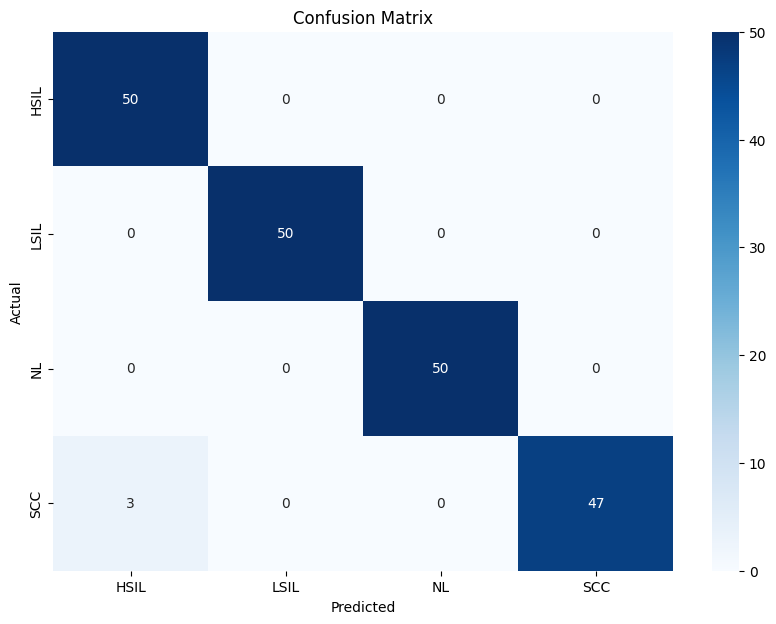

In [ ]:
#Plotting the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred, labels=best_model.classes_)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

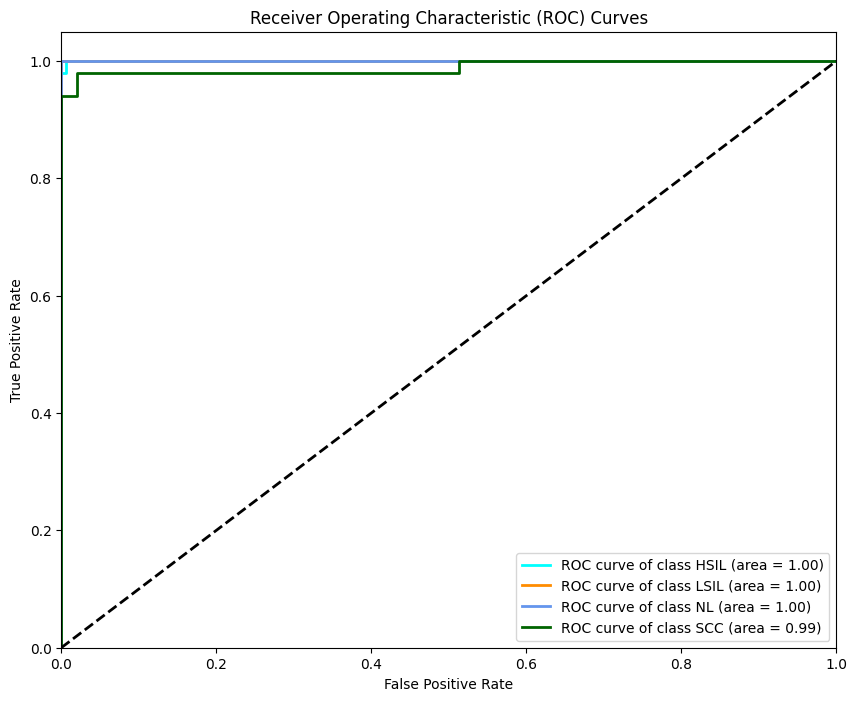

In [ ]:
#Plotting ROC curves

#Converting class labels to binary for multiclass
y_bin = label_binarize(y, classes=best_model.classes_)
n_classes = y_bin.shape[1]

#Predicting probabilities for plotting ROC curves
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_score = best_model.decision_function(X_test)

#Calculating the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plotting all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(best_model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

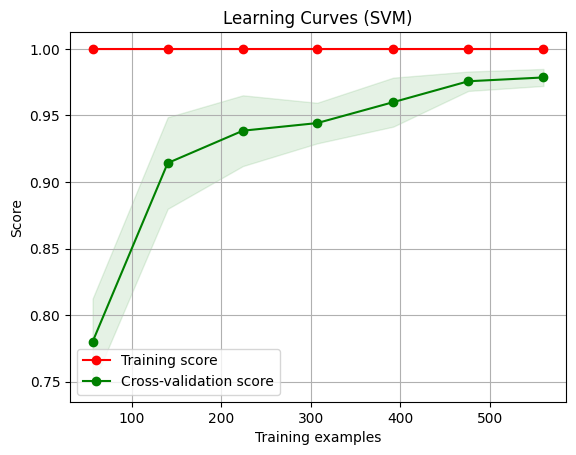

In [ ]:
#Plotting the Learning Curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 7)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(best_model, "Learning Curves (SVM)", X_train, y_train, cv=5, n_jobs=-1)
plt.show()